https://www.kaggle.com/code/andasampa/watershed-delineation-from-dtm/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from google.colab import files
import zipfile
import os

In [5]:
os.chdir("/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM ")
!ls

DSM2.tif  DSM.tif  DTM.tif  n50_e019_1arc_v3.tif  n50_e020_1arc_v3.tif


In [6]:
!pip install google-cloud-storage
from google.cloud import storage

In [7]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.4 MB/s eta 0:00:00


In [9]:
!pip install pysheds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90690 sha256=59816484db8f93f881b3cc33c06cb4dbcf8ce9c2cb08799b3b10ed6735a85753
  Stored in directory: /root/.cache/pip/wheels/8f/2b/0d/988f11a32332312c4d5dfe1720f891789e5b01853f6a842be6
Successfully built pysheds


In [10]:
import rasterio
from pysheds.grid import Grid
from rasterio.plot import show
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
# import os

In [240]:
downscale_factor = 20


with rasterio.open('/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM /DSM2.tif') as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height / downscale_factor),
            int(dataset.width / downscale_factor)
        ),
        out_dtype='uint16'
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    profile = dataset.profile
    profile['nodata'] = '0'
    profile['dtype'] = 'uint16'
    profile['transform'] = transform # Update the profile with the modified transform
    profile['width'] = int(dataset.width / downscale_factor) # Update the profile with the modified width
    profile['height'] = int(dataset.height / downscale_factor) # Update the profile with the modified height


In [271]:
with rasterio.open('/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM /n50_e019_1arc_v3 (1).tif', 'w', **profile) as dst:
    dst.write(np.squeeze(data), 1)

In [276]:
dataset = rasterio.open('/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM /n50_e019_1arc_v3 (1).tif')

In [277]:
dataset.transform, dataset.nodata

(Affine(0.0005555555555555556, 0.0, 18.99972222222222,
        0.0, -0.0002777777777777778, 51.000138888888884),
 -32767.0)

In [278]:
dtm_10 = dataset.read(1)

<Axes: >

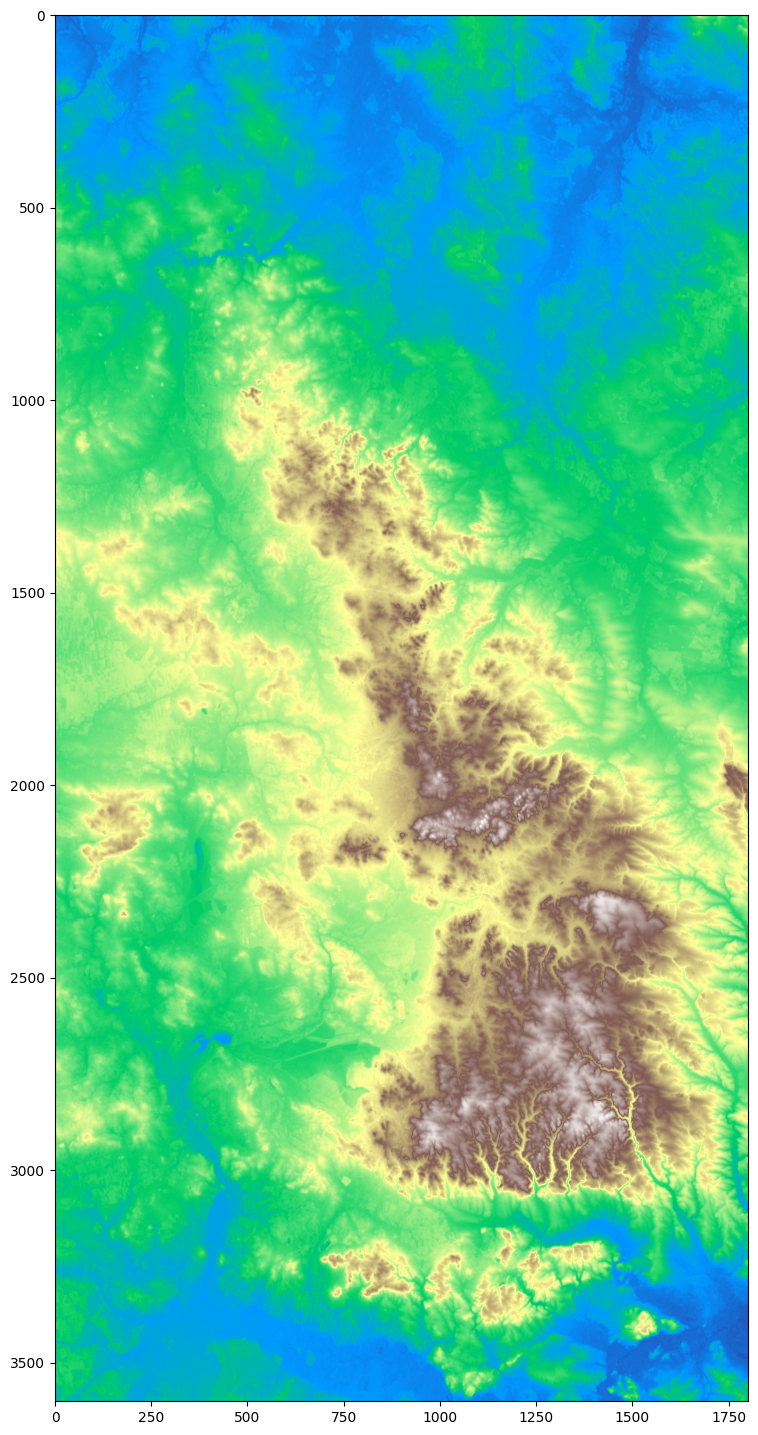

In [279]:
fig, ax = pyplot.subplots(1, 1, figsize=(10,18))
show(dtm_10, cmap='terrain', ax=ax)

In [280]:
grid = Grid.from_raster('/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM /DTM.tif')

In [281]:
dem = grid.read_raster('/content/drive/MyDrive/Dane z Kaggla/Elevation/DEM /DTM.tif')

In [282]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

In [283]:
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

In [284]:
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [285]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [286]:
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

In [287]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

In [288]:
acc.dtype

dtype('float64')

In [289]:
profile['dtype'] = 'float64'
with rasterio.open('acc', 'w', **profile) as dst:
    dst.write(np.squeeze(data), 1)

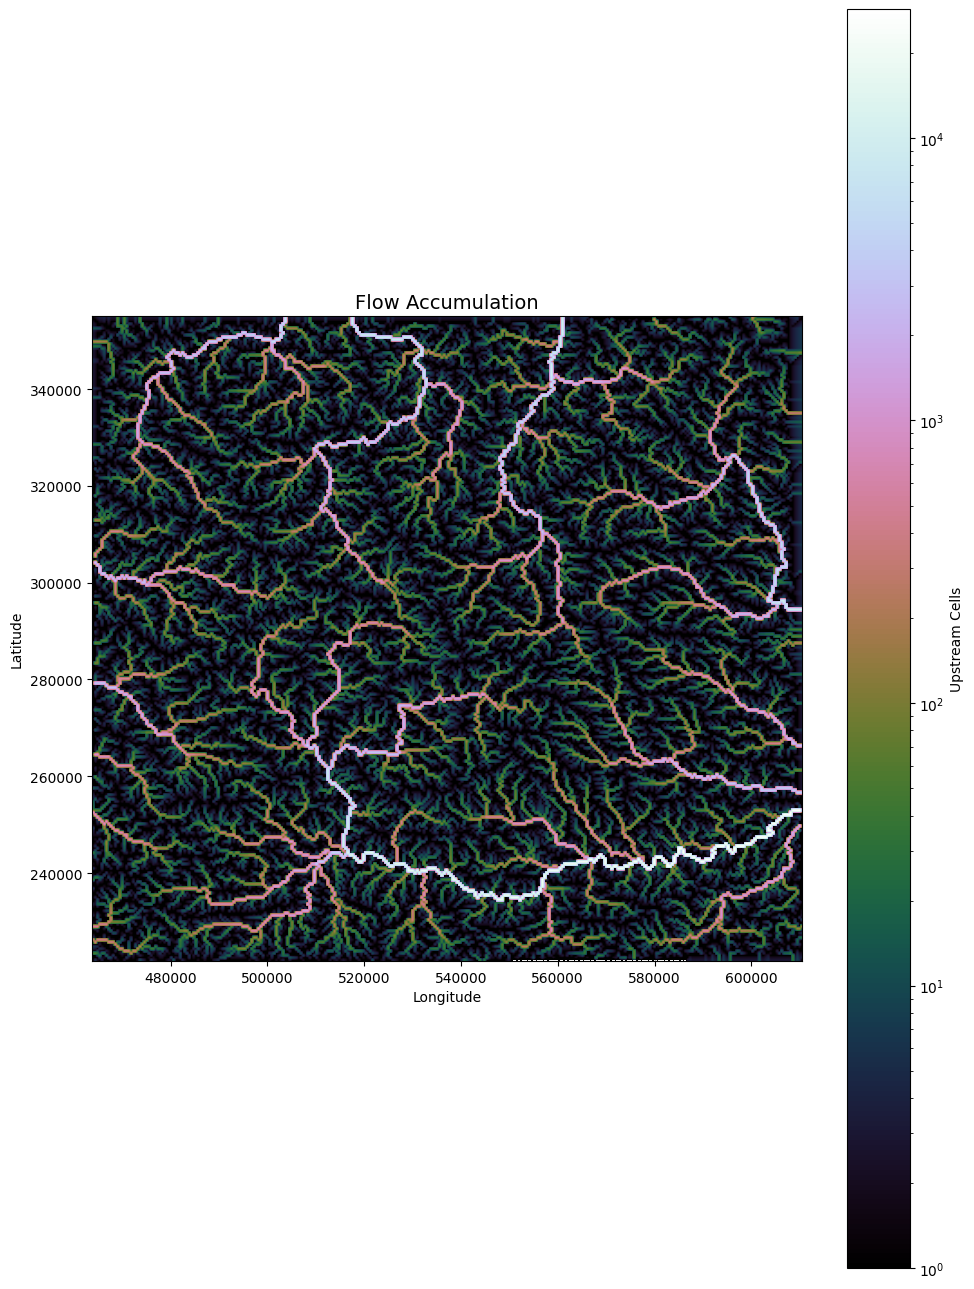

In [290]:
fig, ax = pyplot.subplots(figsize=(10,13))
fig.patch.set_alpha(0)
pyplot.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
pyplot.colorbar(im, ax=ax, label='Upstream Cells')
pyplot.title('Flow Accumulation', size=14)
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
pyplot.tight_layout()

In [291]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = 460000, 220000

In [292]:
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

In [293]:
x_snap

466045.2234886793

In [294]:
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap)


In [295]:
# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

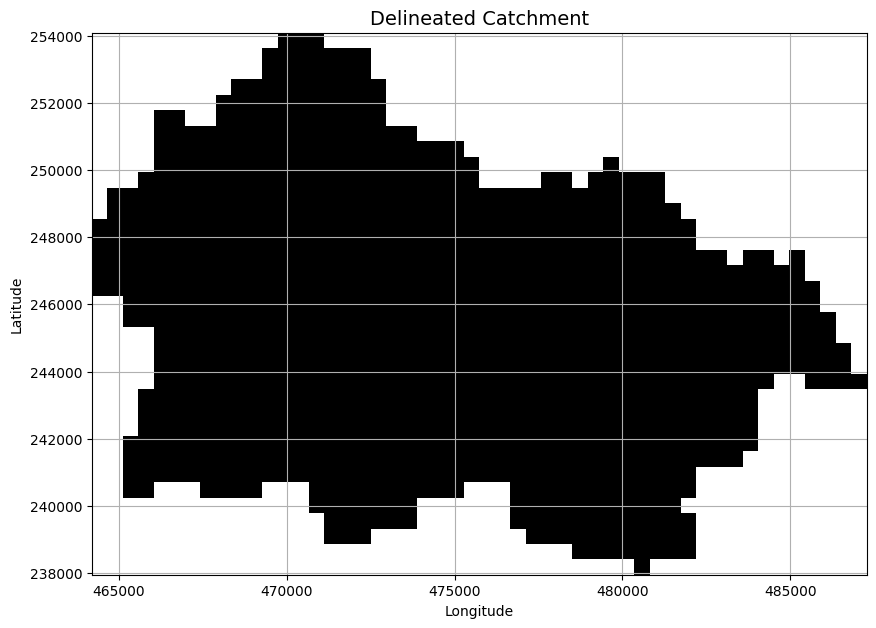

In [296]:
# Plot the catchment
fig, ax = pyplot.subplots(figsize=(10,8))
fig.patch.set_alpha(0)
pyplot.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
pyplot.title('Delineated Catchment', size=14)

In [297]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

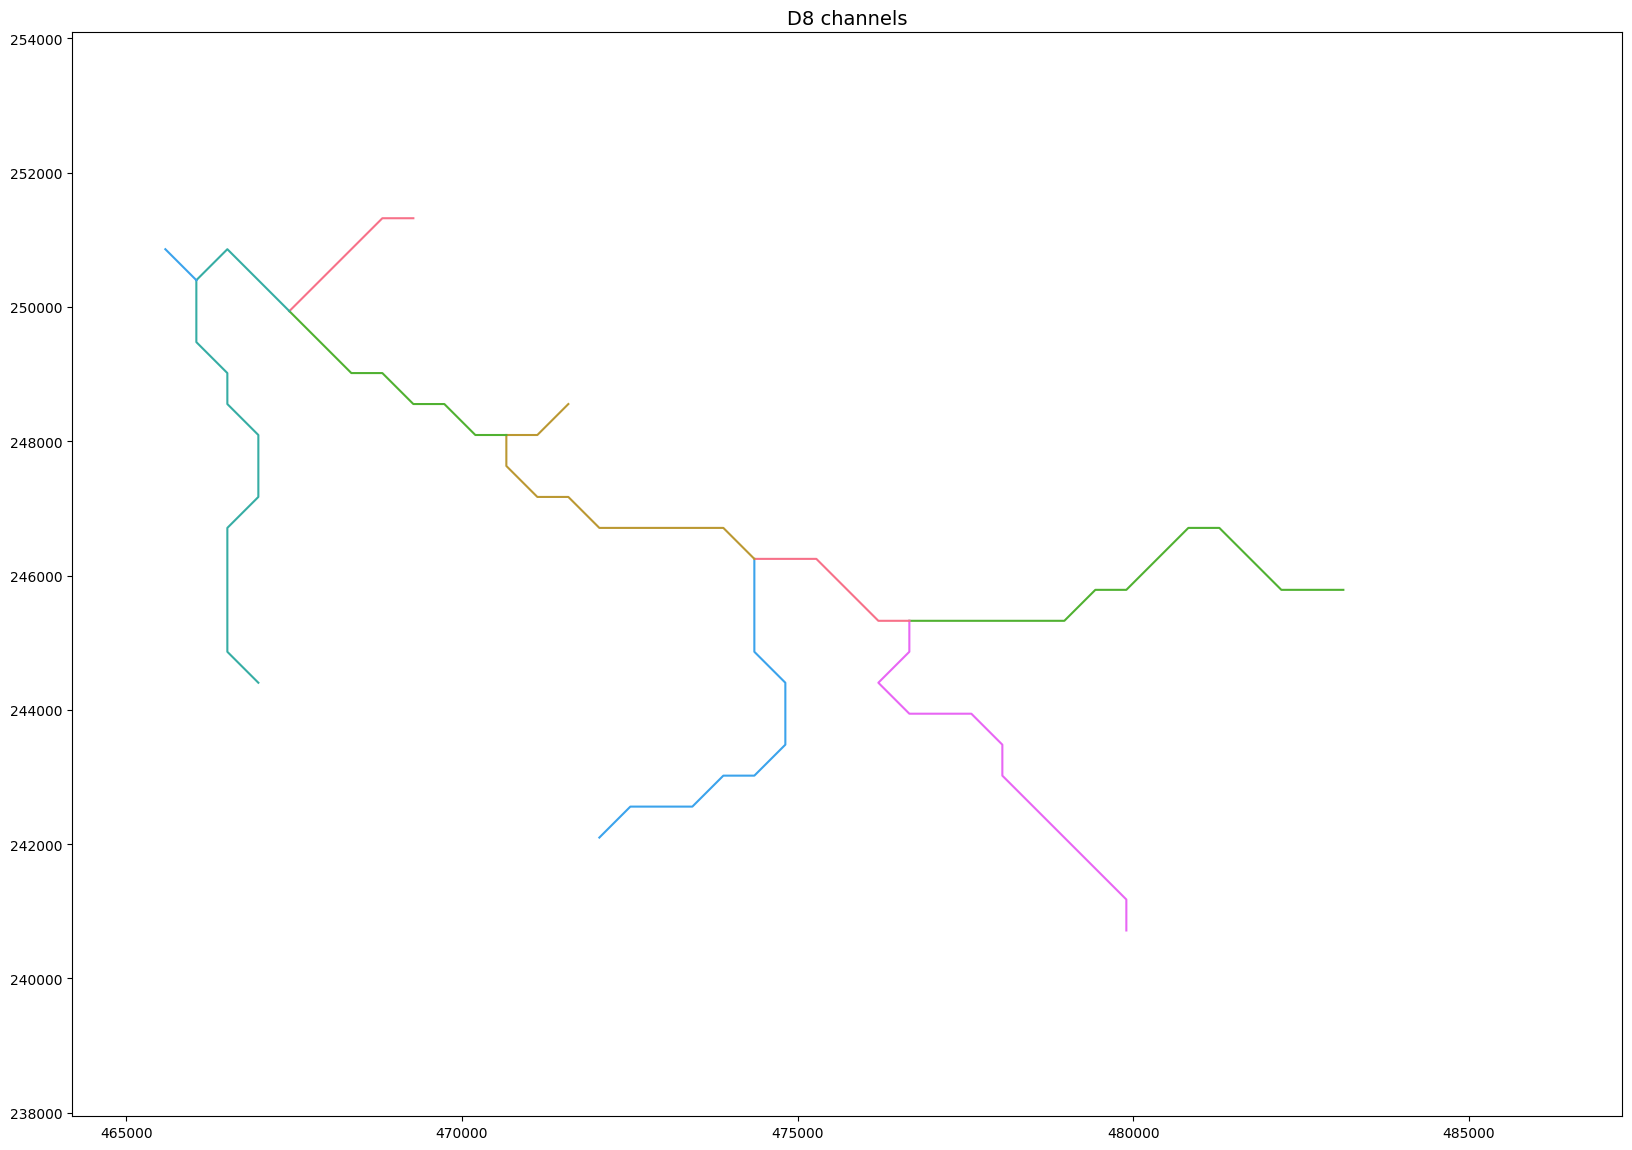

In [298]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(20, 15))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('D8 channels', size=14)

In [299]:
# Calculate distance to outlet from each cell
# -------------------------------------------
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

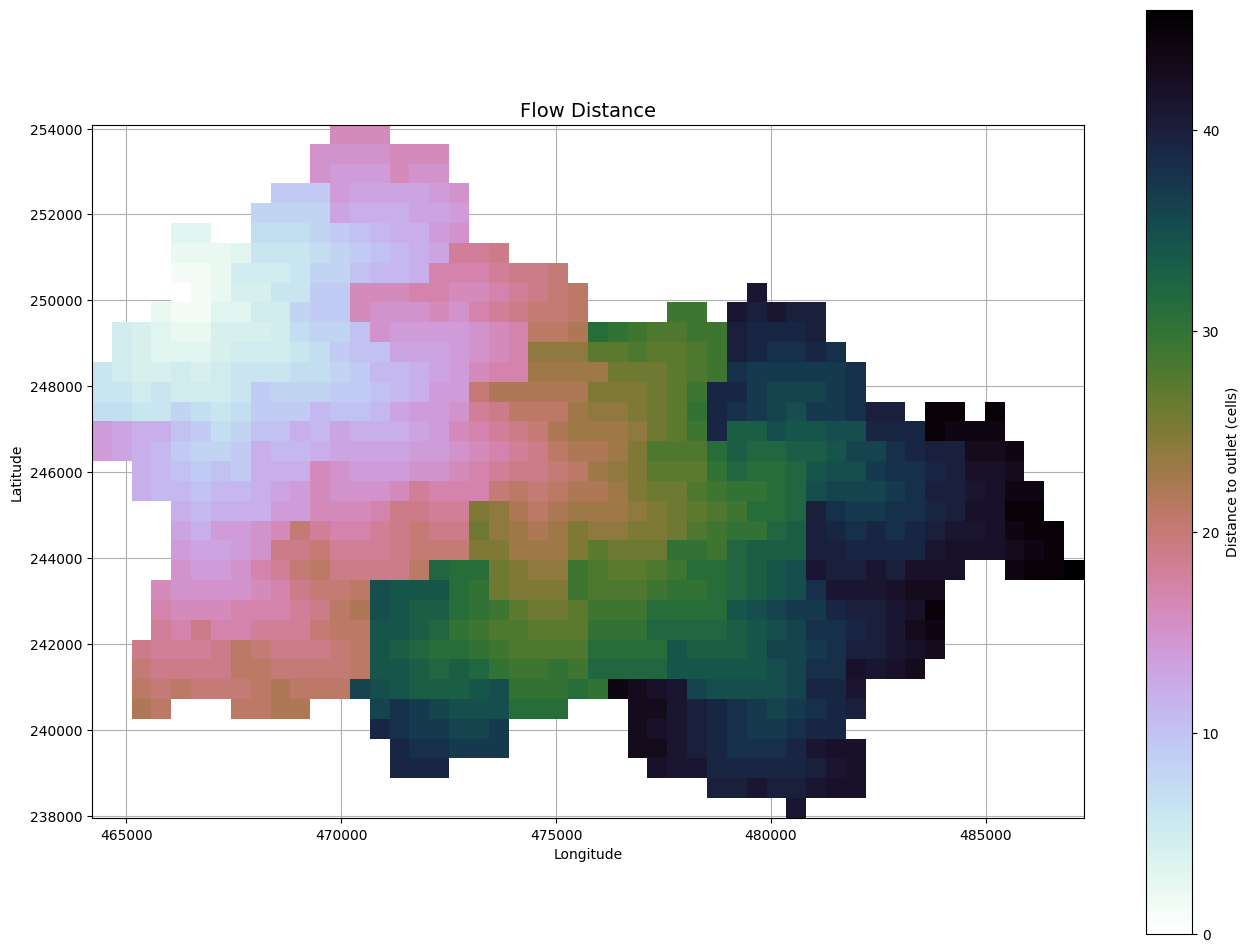

In [300]:
fig, ax = plt.subplots(figsize=(16,12))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)